Imports and upload small dataset scanned from Wikipedia (100 MB)


In [0]:
import gzip
import gensim 
import logging
import pandas as pd
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
from google.colab import files
import sys
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [0]:
data_file='enwiki-latest-abstract1.xml.gz'

Compute lose after each epoch function

In [0]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss


The function that processing and cleaning the file and return a list of words for every line - This method reads the input file which is in gzip format - 

In [0]:
def read_input(input_file):
    """"""
    
    logging.info("reading file {0}...this may take a while".format(input_file))
    
    with gzip.open (input_file, 'rb') as f:
        for i, line in enumerate (f): 

            if (i%10000==0):
                logging.info ("read {0} sentences".format (i))

            # do some pre-processing and return a list of words for each sentence of the text
            yield gensim.utils.simple_preprocess (line)

read the tokenized lines into a list,
each line item becomes a series of words
so this becomes a list of lists

In [5]:
documents = list (read_input (data_file))
logging.info ("Done reading data file")

2020-05-11 09:15:25,002 : INFO : reading file enwiki-latest-abstract1.xml.gz...this may take a while
2020-05-11 09:15:25,005 : INFO : read 0 sentences
2020-05-11 09:15:25,239 : INFO : read 10000 sentences
2020-05-11 09:15:25,447 : INFO : read 20000 sentences
2020-05-11 09:15:25,673 : INFO : read 30000 sentences
2020-05-11 09:15:25,887 : INFO : read 40000 sentences
2020-05-11 09:15:26,114 : INFO : read 50000 sentences
2020-05-11 09:15:26,439 : INFO : read 60000 sentences
2020-05-11 09:15:26,667 : INFO : read 70000 sentences
2020-05-11 09:15:26,881 : INFO : read 80000 sentences
2020-05-11 09:15:27,106 : INFO : read 90000 sentences
2020-05-11 09:15:27,323 : INFO : read 100000 sentences
2020-05-11 09:15:27,544 : INFO : read 110000 sentences
2020-05-11 09:15:27,766 : INFO : read 120000 sentences
2020-05-11 09:15:27,977 : INFO : read 130000 sentences
2020-05-11 09:15:28,194 : INFO : read 140000 sentences
2020-05-11 09:15:28,564 : INFO : read 150000 sentences
2020-05-11 09:15:28,807 : INFO : 

Training the model with the parameters :  Dimensionality of the word vectors : 150, 
Maximum distance between the current and predicted word within a sentence: 10 ,  Ignores all words with total frequency lower than : 2, Training algorithm - Cbow , Accelerator : Negative Sampling, number of epochs = 4 (enough for loss = 0)

In [6]:
model = gensim.models.Word2Vec (documents, size=150, window=9, min_count=2, workers=10,sg = 0, hs =0,compute_loss=True, callbacks=[callback()] )
model.train(documents,total_examples=len(documents),epochs=4)



2020-05-11 09:18:47,896 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2020-05-11 09:18:47,897 : INFO : collecting all words and their counts
2020-05-11 09:18:47,898 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-11 09:18:47,932 : INFO : PROGRESS: at sentence #10000, processed 137606 words, keeping 6986 word types
2020-05-11 09:18:47,958 : INFO : PROGRESS: at sentence #20000, processed 264896 words, keeping 11403 word types
2020-05-11 09:18:47,987 : INFO : PROGRESS: at sentence #30000, processed 394834 words, keeping 15354 word types
2020-05-11 09:18:48,016 : INFO : PROGRESS: at sentence #40000, processed 526798 words, keeping 18279 word types
2020-05-11 09:18:48,046 : INFO : PROGRESS: at sentence #50000, processed 662679 words, keeping 21555 word types
2020-05-11 09:18:48,075 : INFO : PROGRESS: at sentence #60000, processed 797919 words, keeping 24252 word types
2020-05-11 09:18:48,109 : INFO : PROGRESS: at senten

Loss after epoch 0: 7219917.0


2020-05-11 09:23:19,115 : INFO : EPOCH 2 - PROGRESS: at 0.66% examples, 285351 words/s, in_qsize 19, out_qsize 1
2020-05-11 09:23:20,122 : INFO : EPOCH 2 - PROGRESS: at 1.41% examples, 307483 words/s, in_qsize 20, out_qsize 0
2020-05-11 09:23:21,161 : INFO : EPOCH 2 - PROGRESS: at 2.13% examples, 306752 words/s, in_qsize 19, out_qsize 1
2020-05-11 09:23:22,182 : INFO : EPOCH 2 - PROGRESS: at 2.85% examples, 306177 words/s, in_qsize 18, out_qsize 1
2020-05-11 09:23:23,193 : INFO : EPOCH 2 - PROGRESS: at 3.60% examples, 311393 words/s, in_qsize 20, out_qsize 0
2020-05-11 09:23:24,196 : INFO : EPOCH 2 - PROGRESS: at 4.31% examples, 310958 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:23:25,215 : INFO : EPOCH 2 - PROGRESS: at 5.14% examples, 311817 words/s, in_qsize 20, out_qsize 0
2020-05-11 09:23:26,225 : INFO : EPOCH 2 - PROGRESS: at 5.85% examples, 311330 words/s, in_qsize 18, out_qsize 1
2020-05-11 09:23:27,284 : INFO : EPOCH 2 - PROGRESS: at 6.62% examples, 311202 words/s, in_qsize

Loss after epoch 1: 5642930.0


2020-05-11 09:25:22,299 : INFO : EPOCH 3 - PROGRESS: at 0.64% examples, 273226 words/s, in_qsize 20, out_qsize 9
2020-05-11 09:25:23,298 : INFO : EPOCH 3 - PROGRESS: at 1.42% examples, 307885 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:25:24,364 : INFO : EPOCH 3 - PROGRESS: at 2.14% examples, 304314 words/s, in_qsize 19, out_qsize 6
2020-05-11 09:25:25,365 : INFO : EPOCH 3 - PROGRESS: at 2.88% examples, 308612 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:25:26,406 : INFO : EPOCH 3 - PROGRESS: at 3.62% examples, 310268 words/s, in_qsize 19, out_qsize 5
2020-05-11 09:25:27,436 : INFO : EPOCH 3 - PROGRESS: at 4.41% examples, 313713 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:25:28,448 : INFO : EPOCH 3 - PROGRESS: at 5.18% examples, 312225 words/s, in_qsize 15, out_qsize 4
2020-05-11 09:25:29,452 : INFO : EPOCH 3 - PROGRESS: at 5.98% examples, 316105 words/s, in_qsize 20, out_qsize 0
2020-05-11 09:25:30,454 : INFO : EPOCH 3 - PROGRESS: at 6.68% examples, 314265 words/s, in_qsize

Loss after epoch 2: 4842935.0


2020-05-11 09:27:25,477 : INFO : EPOCH 4 - PROGRESS: at 0.69% examples, 297413 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:27:26,482 : INFO : EPOCH 4 - PROGRESS: at 1.45% examples, 315083 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:27:27,484 : INFO : EPOCH 4 - PROGRESS: at 2.18% examples, 315526 words/s, in_qsize 18, out_qsize 1
2020-05-11 09:27:28,494 : INFO : EPOCH 4 - PROGRESS: at 2.86% examples, 311295 words/s, in_qsize 16, out_qsize 3
2020-05-11 09:27:29,508 : INFO : EPOCH 4 - PROGRESS: at 3.59% examples, 312516 words/s, in_qsize 16, out_qsize 3
2020-05-11 09:27:30,546 : INFO : EPOCH 4 - PROGRESS: at 4.34% examples, 313441 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:27:31,605 : INFO : EPOCH 4 - PROGRESS: at 5.22% examples, 315781 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:27:32,628 : INFO : EPOCH 4 - PROGRESS: at 5.98% examples, 316432 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:27:33,629 : INFO : EPOCH 4 - PROGRESS: at 6.75% examples, 317672 words/s, in_qsize

Loss after epoch 3: 3522166.0


2020-05-11 09:29:27,724 : INFO : EPOCH 5 - PROGRESS: at 0.70% examples, 292159 words/s, in_qsize 15, out_qsize 4
2020-05-11 09:29:28,730 : INFO : EPOCH 5 - PROGRESS: at 1.47% examples, 313914 words/s, in_qsize 18, out_qsize 3
2020-05-11 09:29:29,741 : INFO : EPOCH 5 - PROGRESS: at 2.20% examples, 314855 words/s, in_qsize 17, out_qsize 2
2020-05-11 09:29:30,792 : INFO : EPOCH 5 - PROGRESS: at 2.95% examples, 315425 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:29:31,818 : INFO : EPOCH 5 - PROGRESS: at 3.71% examples, 318587 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:29:32,805 : INFO : EPOCH 5 - PROGRESS: at 4.54% examples, 322099 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:29:33,815 : INFO : EPOCH 5 - PROGRESS: at 5.32% examples, 322132 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:29:34,843 : INFO : EPOCH 5 - PROGRESS: at 6.09% examples, 322050 words/s, in_qsize 20, out_qsize 2
2020-05-11 09:29:35,847 : INFO : EPOCH 5 - PROGRESS: at 6.84% examples, 321701 words/s, in_qsize

Loss after epoch 4: 3410970.0


2020-05-11 09:31:29,751 : INFO : EPOCH 1 - PROGRESS: at 0.71% examples, 294859 words/s, in_qsize 20, out_qsize 1
2020-05-11 09:31:30,758 : INFO : EPOCH 1 - PROGRESS: at 1.48% examples, 316674 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:31:31,781 : INFO : EPOCH 1 - PROGRESS: at 2.22% examples, 315442 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:31:32,820 : INFO : EPOCH 1 - PROGRESS: at 2.88% examples, 309386 words/s, in_qsize 19, out_qsize 4
2020-05-11 09:31:33,825 : INFO : EPOCH 1 - PROGRESS: at 3.63% examples, 311931 words/s, in_qsize 20, out_qsize 0
2020-05-11 09:31:34,859 : INFO : EPOCH 1 - PROGRESS: at 4.39% examples, 313670 words/s, in_qsize 18, out_qsize 3
2020-05-11 09:31:35,865 : INFO : EPOCH 1 - PROGRESS: at 5.23% examples, 315634 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:31:36,976 : INFO : EPOCH 1 - PROGRESS: at 6.01% examples, 314047 words/s, in_qsize 20, out_qsize 5
2020-05-11 09:31:38,024 : INFO : EPOCH 1 - PROGRESS: at 6.82% examples, 315809 words/s, in_qsize

Loss after epoch 5: -24638918.0


2020-05-11 09:33:36,343 : INFO : EPOCH 2 - PROGRESS: at 0.70% examples, 285856 words/s, in_qsize 17, out_qsize 2
2020-05-11 09:33:37,360 : INFO : EPOCH 2 - PROGRESS: at 1.45% examples, 305347 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:33:38,368 : INFO : EPOCH 2 - PROGRESS: at 2.18% examples, 308094 words/s, in_qsize 18, out_qsize 1
2020-05-11 09:33:39,384 : INFO : EPOCH 2 - PROGRESS: at 2.90% examples, 309490 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:33:40,389 : INFO : EPOCH 2 - PROGRESS: at 3.59% examples, 309057 words/s, in_qsize 20, out_qsize 2
2020-05-11 09:33:41,403 : INFO : EPOCH 2 - PROGRESS: at 4.32% examples, 310058 words/s, in_qsize 20, out_qsize 0
2020-05-11 09:33:42,424 : INFO : EPOCH 2 - PROGRESS: at 5.14% examples, 309999 words/s, in_qsize 20, out_qsize 0
2020-05-11 09:33:43,427 : INFO : EPOCH 2 - PROGRESS: at 5.91% examples, 313113 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:33:44,436 : INFO : EPOCH 2 - PROGRESS: at 6.67% examples, 314094 words/s, in_qsize

Loss after epoch 6: 0.0


2020-05-11 09:35:43,589 : INFO : EPOCH 3 - PROGRESS: at 0.67% examples, 275553 words/s, in_qsize 20, out_qsize 0
2020-05-11 09:35:44,618 : INFO : EPOCH 3 - PROGRESS: at 1.39% examples, 294025 words/s, in_qsize 19, out_qsize 3
2020-05-11 09:35:45,624 : INFO : EPOCH 3 - PROGRESS: at 2.13% examples, 301449 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:35:46,628 : INFO : EPOCH 3 - PROGRESS: at 2.83% examples, 302846 words/s, in_qsize 17, out_qsize 2
2020-05-11 09:35:47,679 : INFO : EPOCH 3 - PROGRESS: at 3.49% examples, 298135 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:35:48,742 : INFO : EPOCH 3 - PROGRESS: at 4.24% examples, 300394 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:35:49,745 : INFO : EPOCH 3 - PROGRESS: at 5.04% examples, 301976 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:35:50,747 : INFO : EPOCH 3 - PROGRESS: at 5.75% examples, 301971 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:35:51,768 : INFO : EPOCH 3 - PROGRESS: at 6.44% examples, 300809 words/s, in_qsize

Loss after epoch 7: 0.0


2020-05-11 09:37:50,300 : INFO : EPOCH 4 - PROGRESS: at 0.66% examples, 286651 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:37:51,302 : INFO : EPOCH 4 - PROGRESS: at 1.37% examples, 299531 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:37:52,310 : INFO : EPOCH 4 - PROGRESS: at 2.08% examples, 302283 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:37:53,388 : INFO : EPOCH 4 - PROGRESS: at 2.84% examples, 303948 words/s, in_qsize 17, out_qsize 4
2020-05-11 09:37:54,436 : INFO : EPOCH 4 - PROGRESS: at 3.59% examples, 307363 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:37:55,452 : INFO : EPOCH 4 - PROGRESS: at 4.35% examples, 310312 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:37:56,477 : INFO : EPOCH 4 - PROGRESS: at 5.17% examples, 310480 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:37:57,479 : INFO : EPOCH 4 - PROGRESS: at 5.93% examples, 312819 words/s, in_qsize 19, out_qsize 0
2020-05-11 09:37:58,504 : INFO : EPOCH 4 - PROGRESS: at 6.66% examples, 312067 words/s, in_qsize

Loss after epoch 8: 0.0


(154513184, 428019492)

Model latest loss:

In [7]:
model.get_latest_training_loss()


0.0

Top 10 similar words to the word "king"




In [8]:
w1 = "king"
model.wv.most_similar (positive=w1)

2020-05-11 09:39:53,504 : INFO : precomputing L2-norms of word weight vectors


[('prince', 0.6867810487747192),
 ('kings', 0.6809967756271362),
 ('queen', 0.6687802672386169),
 ('regent', 0.6139390468597412),
 ('vi', 0.609061062335968),
 ('consort', 0.6089320778846741),
 ('reigned', 0.5974293947219849),
 ('son', 0.5924986600875854),
 ('ruler', 0.5894355773925781),
 ('pharaoh', 0.5891453623771667)]

Top 10 similar words to the word "queen"





In [9]:
w1 = "queen"
model.wv.most_similar (positive=w1)

[('princess', 0.678177535533905),
 ('king', 0.6687802076339722),
 ('consort', 0.6684778332710266),
 ('empress', 0.6455979347229004),
 ('regent', 0.6149759292602539),
 ('elizabeth', 0.6020445823669434),
 ('crown', 0.5962712168693542),
 ('monarch', 0.5916584134101868),
 ('prince', 0.5817903280258179),
 ('mistress', 0.5817869901657104)]

Top 10 similar words to the word "israel"





In [10]:
w1 = "israel"
model.wv.most_similar (positive=w1)

[('palestine', 0.7895171046257019),
 ('lebanon', 0.7224624752998352),
 ('syria', 0.6912679076194763),
 ('jerusalem', 0.6789504885673523),
 ('iran', 0.6715242862701416),
 ('egypt', 0.6628424525260925),
 ('iraq', 0.6472344994544983),
 ('israeli', 0.6423652172088623),
 ('in_israel', 0.6361289620399475),
 ('palestinians', 0.6267240047454834)]

Top 10 similar words to the word "mathematics"


In [11]:
w1 = "mathematics"
model.wv.most_similar (positive=w1)

[('algebra', 0.8271865248680115),
 ('geometry', 0.7581013441085815),
 ('combinatorics', 0.7534824013710022),
 ('topology', 0.7458296418190002),
 ('calculus', 0.718076229095459),
 ('arithmetic', 0.6941332221031189),
 ('physics', 0.6855602860450745),
 ('algebraic', 0.6750196814537048),
 ('cohomology', 0.6748274564743042),
 ('mathematical', 0.6721484065055847)]

Similarity:

In [12]:
print(model.wv.similarity("cat", 'dog'))


0.69480586


More similarity :

In [13]:
print(model.wv.similarity("statistics", 'mathematics'))


0.44238374


Dissimilarity:

In [14]:
print(model.wv.similarity("statistics", 'vodka'))


-0.005673769


Surprising result :-)

Here, I ask our model to give us the word that does not belong to the list



In [15]:
print(model.wv.doesnt_match(['mathematics', 'university','statistics', 'frankenstein']))


frankenstein


Analogy difference:
(The classical example)

In [16]:
print(model.wv.most_similar(positive=["woman", "king"], negative=["queen"], topn=1))

[('man', 0.5861272811889648)]


Another example:

In [23]:
print(model.wv.most_similar(positive=["paris", "italy"], negative=["france"], topn=1))

[('rome', 0.707650363445282)]


Last example (Geopolitics)

In [18]:
print(model.wv.most_similar(positive=["iran", "russia"], negative=["israel"], topn=1))

[('ukraine', 0.6773084402084351)]


Visualization via t-SNE (dimensionality reduction algorithm)

In [0]:
def tsnescatterplot(model, word, list_names):

    arrays = np.empty((0, 150), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

10 most similar words from the model, as well as 10 random ones, lies in a 2D graph

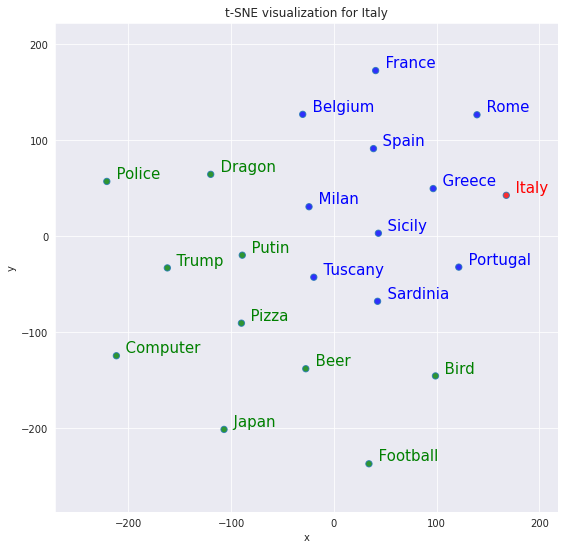

In [24]:
tsnescatterplot(model.wv, 'italy', ['beer', 'bird', 'police', 'trump', 'dragon', 'football', 'pizza', 'computer','putin','japan'])

10 most similar words from the model  compare to the 10 most dissimilar words



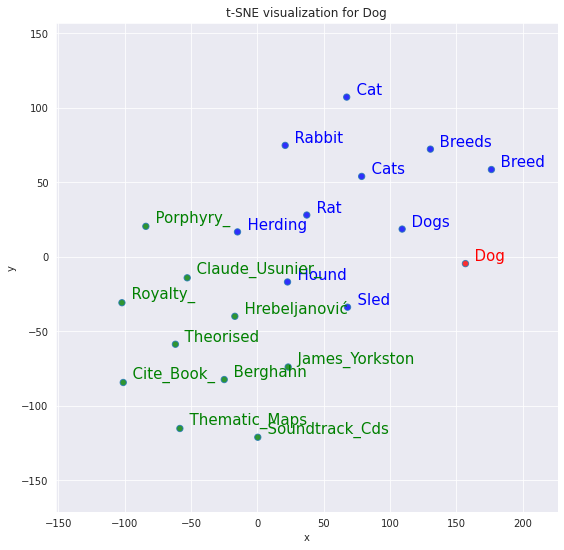

In [21]:
tsnescatterplot(model.wv, 'dog', [i[0] for i in model.wv.most_similar(negative=["basketball"])])

Number of words in the vocabulary:

In [22]:
len(model.wv.vocab)

538098

# Summary
I found that CBOW gave me slightly better results and was better than Skip-gram with the datasets I tried. As Accelerator I used  Negative Sampling because 
Hierarchical softmax just took too much time to run and the results were almost the same. I used google recommendations for window size, the dimensionality of word vectors regarding my corpus size, etc.
Running time was: 20 minutes

